<a href="https://colab.research.google.com/github/Jay-Damodaran/Projects/blob/main/pneumonia_diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I will use a chest x-ray dataset from kaggle with labeled images depicting normal lungs and lungs of pneumonia patients. I will use pytorch to create a deep learning model that is able to produce a diagnosis based on the images.
Data was downloaded from kaggle
https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
The kaggle page cites
https://data.mendeley.com/datasets/rscbjbr9sj/2 as the source for labeled x-ray image data as well as http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5, which is a paper on medical image diagnosis based on deep learning

# Importing Libraries and Configuration

In [ ]:
import pandas as pd
import numpy as np
import os
import shutil
import random
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset as TData
from torch.utils.data import DataLoader as DL
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torchvision.transforms.v2 as ttv2
from torchvision.utils import save_image
from torchsummary import summary
# sklearn functions unable to work with CUDA since they use numpy in backend, no GPU computing
# must rewrite functions using pytorch
# from sklearn.metrics import confusion_matrix as conf_mat
# from sklearn.metrics import accuracy_score as acc
# from sklearn.model_selection import train_test_split as tts

In [ ]:
# check for cuda and use
assert torch.cuda.is_available()
!nvidia-smi
device = 'cuda'

Sat May 18 15:21:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8              12W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install opendatasets --upgrade

# Loading data and Image Folder

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia")

In [ ]:
base_dir = r'/content/chest-xray-pneumonia/chest_xray'
train_ds = ImageFolder(os.path.join(base_dir, 'train'), transform = tt.ToTensor())
val_ds = ImageFolder(os.path.join(base_dir, 'val'), transform = tt.ToTensor())
test_ds = ImageFolder(os.path.join(base_dir, 'test'), transform = tt.ToTensor())

# Dataset Exploration

In [ ]:
# dataset imbalance- much more pneumonia than normal images
print(len(os.listdir(os.path.join(base_dir, 'train/NORMAL'))))
print(len(os.listdir(os.path.join(base_dir, 'train/PNEUMONIA'))))

1341
3875


In [ ]:
print(f'''training set: {len(train_ds)} images
validation set: {len(val_ds)} images
testing set: {len(test_ds)} images
''')
# Only 16 images for validation, so I will try to redistribute some training images to validation set

training set: 5216 images
validation set: 16 images
testing set: 624 images



In [ ]:
train_ds = train_ds + val_ds
len(train_ds)

5232

In [ ]:
img, label = train_ds[0]
print(img.shape) # 1858 x 2090 image. Will have to resize
print(label)

torch.Size([3, 1858, 2090])
0


In [ ]:
img[0:5, 0:5] # Images already normalized
print(torch.max(img))
print(torch.min(img))

tensor(1.)
tensor(0.)


In [ ]:
# checking that image sizes are standardized by randomly selecting 30 images
def check_const_size(ds, n=30):
    global inds
    inds = np.random.choice(np.arange(len(ds)), n, replace = False)
    for ind in inds:
        if ds[ind][0].shape != img.shape:
            print('Image dimensions inconsistent across dataset')
            break

check_const_size(train_ds) # need to standardize everything by passing tt.Resize() transform

Image dimensions inconsistent across dataset


# Image Visualization

In [ ]:
label_dict = {0: 'normal',
              1: 'pneumonia'}

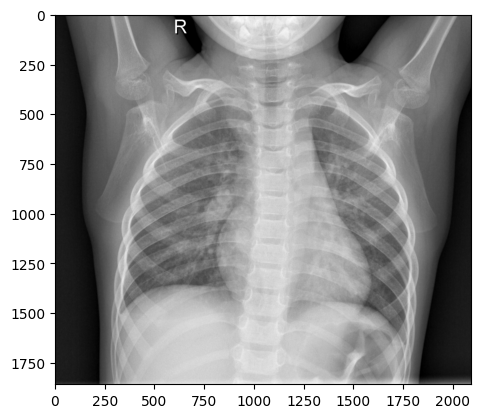

In [ ]:
plt.imshow(img.permute(1, 2, 0)) # shows x-ray of normal lungs

Text(0.5, 1.0, 'pneumonia')

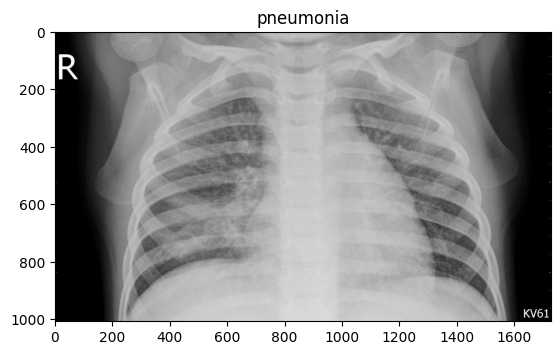

In [ ]:
plt.imshow(train_ds[4500][0].permute(1, 2, 0));
plt.title(label_dict.get(train_ds[4500][1]))

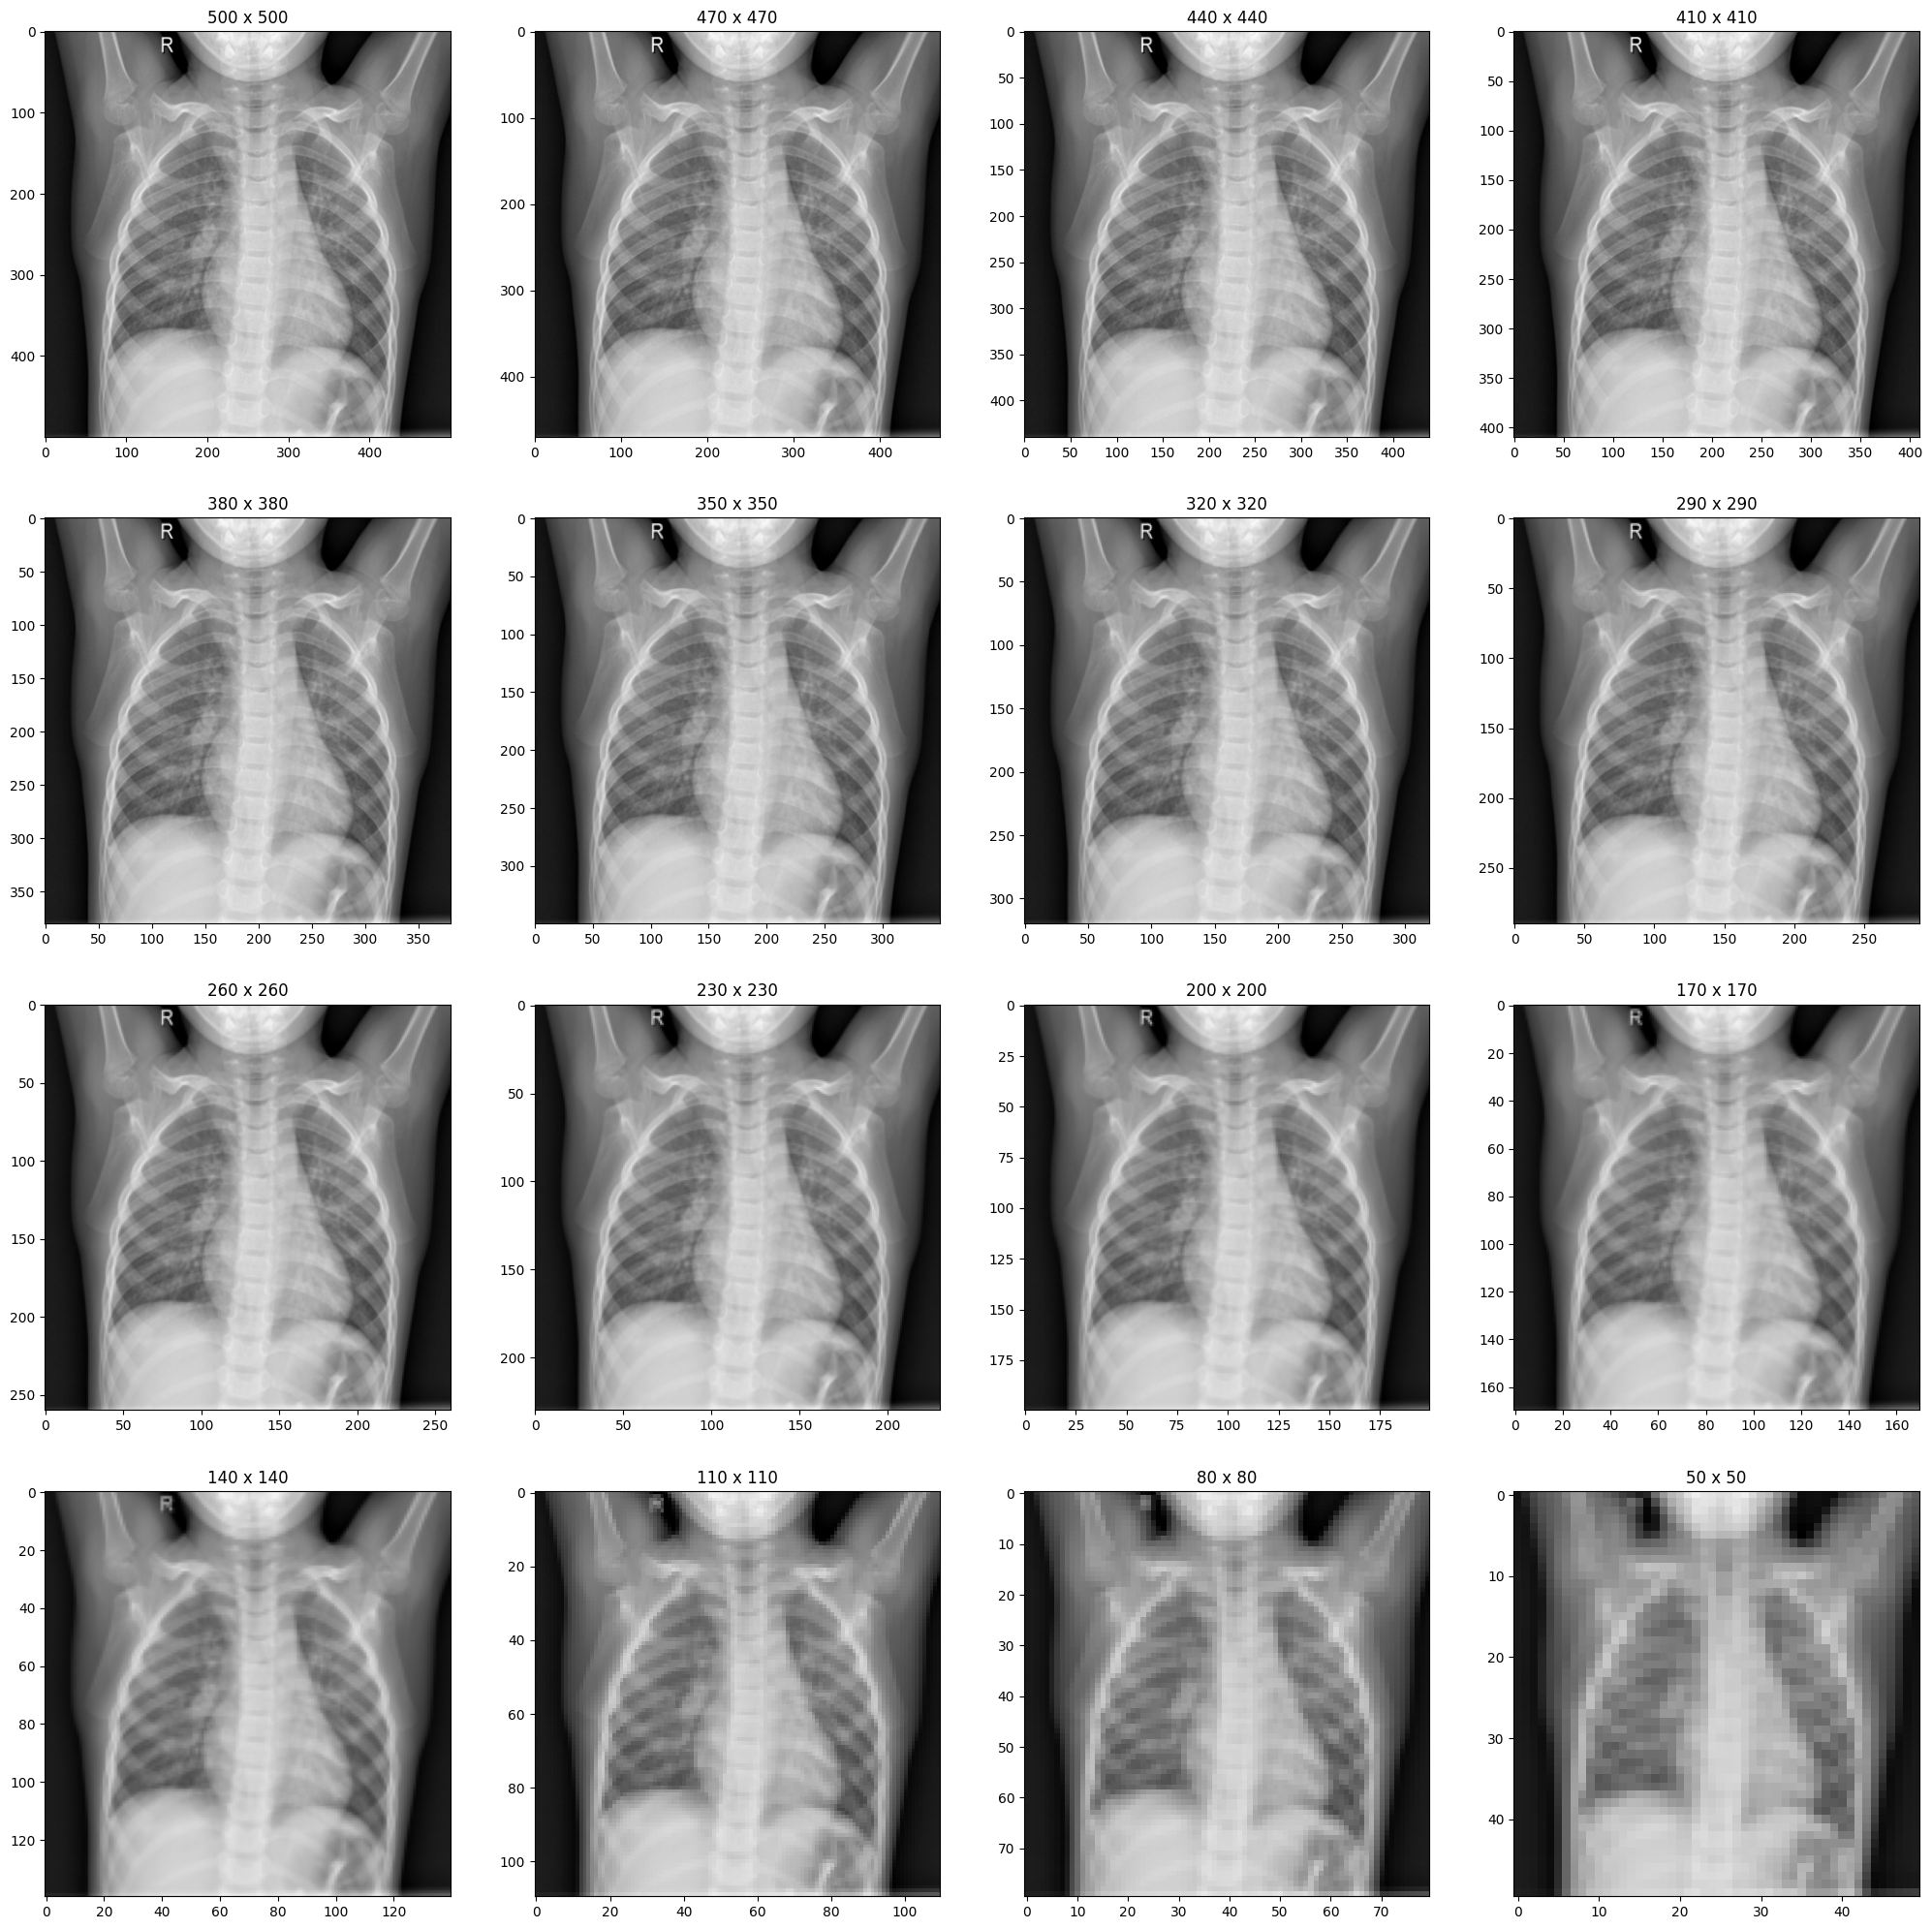

In [ ]:
# determining smallest image size that seems clear enough qualitatively
plt.figure(figsize = (25, 25))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    resizer = tt.Resize((500 - (30 * i), 500 - (30 * i)))
    resized_img = resizer.forward(img)
    plt.imshow(resized_img.permute(1, 2, 0))
    plt.title(f'{500 - (30 * i)} x {500 - (30 * i)}')

# 250 x 250 seems like a conservative choice for image size reduction
# images are still clear at lower resolutions

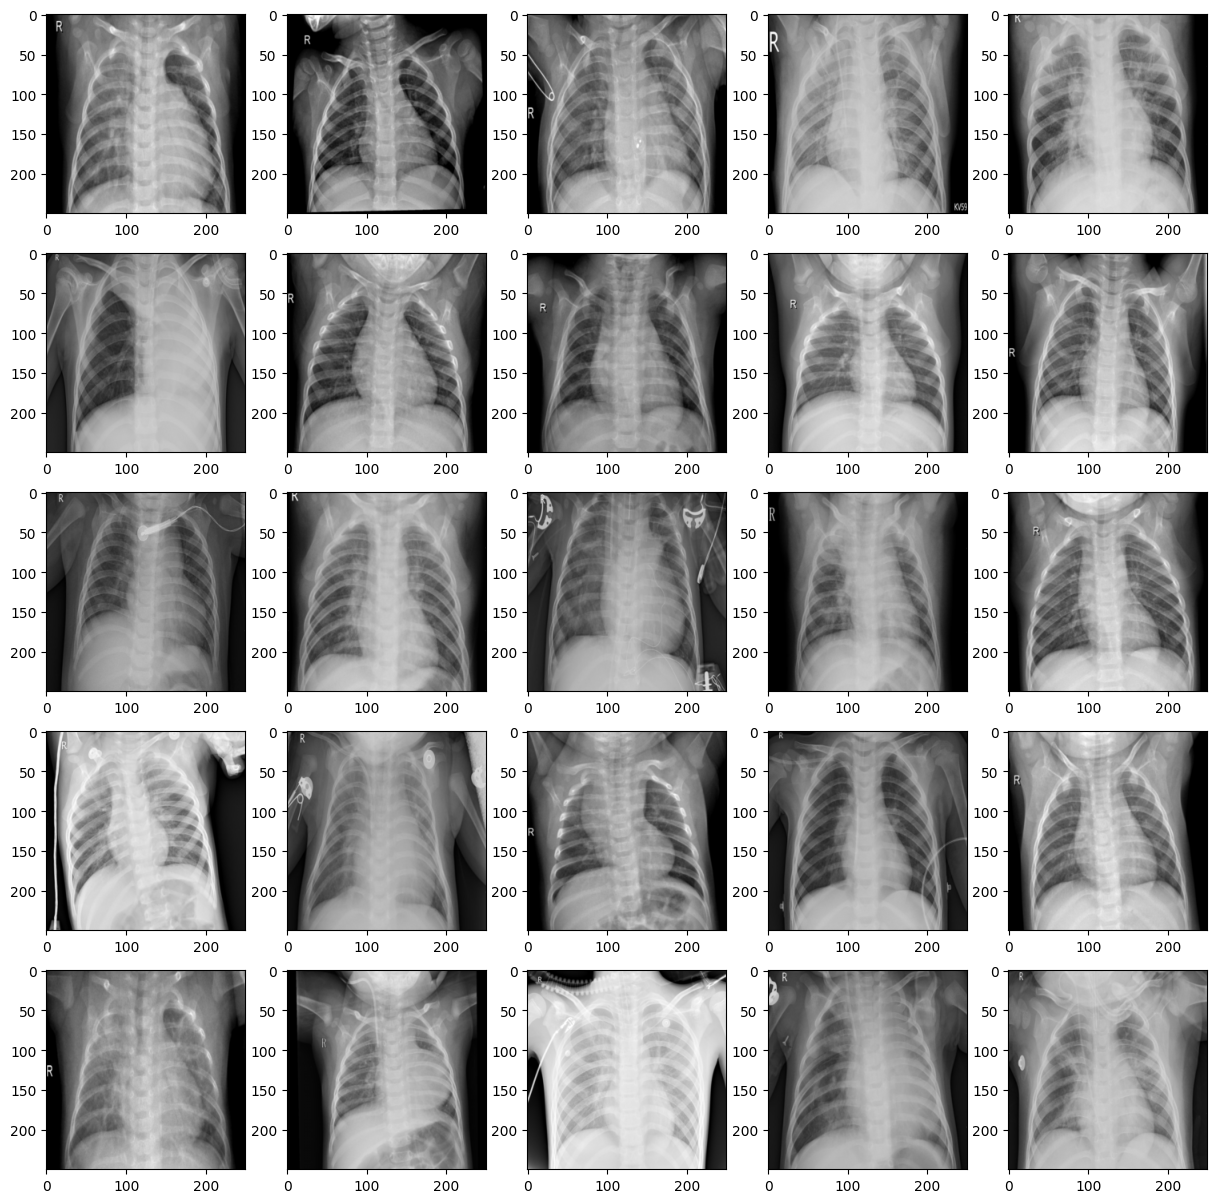

In [ ]:
# visualizing some images
plt.figure(figsize = (15, 15))
resizer = tt.Resize((250, 250))
labels = torch.empty(25)
for i in range(25):
    plt.subplot(5, 5, i + 1)
    img, label = train_ds[inds[i]]
    img = resizer.forward(img)
    plt.imshow(img.permute(1, 2, 0));
    labels[i] = label

In [ ]:
print(labels)

tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0.,
        1., 0., 1., 1., 1., 1., 1.])


# Data loader implementation

In [ ]:
batch_size = 32

train_ds = ImageFolder(os.path.join(base_dir, 'train'), transform = tt.Compose([tt.ToTensor(),
                                                                               tt.Resize((250, 250))]))
val_ds = ImageFolder(os.path.join(base_dir, 'val'), transform = tt.Compose([tt.ToTensor(),
                                                                             tt.Resize((250, 250))]))
test_ds = ImageFolder(os.path.join(base_dir, 'test'), transform = tt.Compose([tt.ToTensor(),
                                                                             tt.Resize((250, 250))]))

# combining training and validation images and redistributing more favorably
train_subset, val_subset = torch.utils.data.random_split(train_ds + val_ds, [0.8, 0.2])
train_dl = iter(DL(train_subset, batch_size = batch_size, shuffle = True, pin_memory = True))
val_dl = iter(DL(val_subset, batch_size = batch_size, shuffle=True, pin_memory=True))
test_dl = iter(DL(test_ds, batch_size = batch_size, shuffle = True, pin_memory = True))

In [ ]:
for i in range(10):
    _, labels = next(test_dl)
    print(labels)

tensor([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
        1, 0, 1, 1, 1, 1, 0, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,
        0, 1, 1, 1, 0, 0, 1, 0])
tensor([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0,
        0, 1, 1, 0, 0, 1, 1, 0])
tensor([1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 0, 1, 0, 0, 0])
tensor([1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1,
        1, 0, 1, 1, 1, 0, 1, 0])
tensor([1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
        0, 0, 1, 0, 0, 1, 0, 0])
tensor([0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
        1, 1, 1, 0, 1, 0, 0, 0])
tensor([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
        1, 1, 1,

# Basic Convnet Model

In [ ]:
class ConvModel(torch.nn.Module):
    def __init__(self, classes=2):
        super().__init__()
        self.conv1 = torch.nn.Sequential(torch.nn.Conv2d(3, 32, (3, 3), padding = 'same'),
                                         torch.nn.ReLU(),
                                         torch.nn.MaxPool2d((2, 2), stride=2)) # output shape = (bs, 32, 125, 125)
        self.conv1[0].weight = torch.nn.init.kaiming_normal_(self.conv1[0].weight, nonlinearity = 'relu')
        self.conv2 = torch.nn.Sequential(torch.nn.Conv2d(32, 32, (3, 3), padding='same'),
                                         torch.nn.ReLU(),
                                         torch.nn.MaxPool2d((2, 2), stride=2)) # output shape = (bs, 32, 62, 62)
        self.conv2[0].weight = torch.nn.init.kaiming_normal_(self.conv2[0].weight, nonlinearity = 'relu')
        self.conv3 = torch.nn.Sequential(torch.nn.Conv2d(32, 64, (3, 3), padding='same'),
                                         torch.nn.ReLU(),
                                         torch.nn.MaxPool2d((2, 2), stride=2)) # output shape = (bs, 64, 31, 31)
        self.conv3[0].weight = torch.nn.init.kaiming_normal_(self.conv3[0].weight, nonlinearity = 'relu')
        self.flatten = torch.nn.Flatten()
        self.dense = torch.nn.Linear(64 * 31 * 31, 128) # max pool cuts image size by half each time
        self.dense.weight = torch.nn.init.kaiming_normal_(self.dense.weight, nonlinearity = 'relu')
        self.output = torch.nn.Linear(128, 1)
        self.output.weight = torch.nn.init.xavier_normal_(self.output.weight)

    def forward(self, x):
        y = self.conv1(x)
        y = self.conv2(y)
        y = self.conv3(y)
        y = self.flatten(y)
        y = torch.nn.functional.relu(self.dense(y))
        y = self.output(y)
        return y

    def reset_weights(self):
        self.conv1[0].weight = torch.nn.init.kaiming_normal_(self.conv1[0].weight, nonlinearity = 'relu')
        self.conv2[0].weight = torch.nn.init.kaiming_normal_(self.conv2[0].weight, nonlinearity = 'relu')
        self.conv3[0].weight = torch.nn.init.kaiming_normal_(self.conv3[0].weight, nonlinearity = 'relu')
        self.dense.weight = torch.nn.init.kaiming_normal_(self.dense.weight, nonlinearity = 'relu')
        self.output.weight = torch.nn.init.xavier_normal_(self.output.weight)


convnet = ConvModel()
convnet.to(device)
summary(convnet, input_size = (3, 250, 250))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 250, 250]             896
              ReLU-2         [-1, 32, 250, 250]               0
         MaxPool2d-3         [-1, 32, 125, 125]               0
            Conv2d-4         [-1, 32, 125, 125]           9,248
              ReLU-5         [-1, 32, 125, 125]               0
         MaxPool2d-6           [-1, 32, 62, 62]               0
            Conv2d-7           [-1, 64, 62, 62]          18,496
              ReLU-8           [-1, 64, 62, 62]               0
         MaxPool2d-9           [-1, 64, 31, 31]               0
          Flatten-10                [-1, 61504]               0
           Linear-11                  [-1, 128]       7,872,640
           Linear-12                    [-1, 1]             129
Total params: 7,901,409
Trainable params: 7,901,409
Non-trainable params: 0
---------------------------

## Training Loop

In [ ]:
free, total = torch.cuda.mem_get_info()
print("Percent Memory Available:", free / total * 100)

Percent Memory Available: 83.61151001725757


In [ ]:
convnet.reset_weights()
epochs = 80
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(convnet.parameters())
train_loss = []
val_loss = []

for n in range(epochs):
    try:
        image_batch, label_batch = next(train_dl)
        val_image_batch, val_label_batch = next(val_dl)
    except StopIteration:
        train_dl = iter(DL(train_subset, batch_size = batch_size, shuffle = True, pin_memory = True))
        val_dl = iter(DL(val_subset, batch_size = batch_size, shuffle=True, pin_memory = True))
        image_batch, label_batch = next(train_dl)
        val_image_batch, val_label_batch = next(val_dl)
    finally:
        image_batch = image_batch.to(device)
        label_batch = label_batch.to(device)

        # forward pass
        convnet.train()
        y_pred = convnet(image_batch)
        loss = criterion(torch.squeeze(y_pred, -1), label_batch.float())

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

        # validation
        val_image_batch = val_image_batch.to(device)
        val_label_batch = val_label_batch.to(device)

        convnet.eval()
        y_pred = convnet(val_image_batch)
        loss = criterion(torch.squeeze(y_pred, -1), val_label_batch.float())
        val_loss.append(loss.item())

    if (n + 1) % 5 == 0:
        print(f'Epoch {n + 1}    loss:{train_loss[-1]:.4f}    val loss: {val_loss[-1]:.4f}')

Epoch 5    loss:1.9422    val loss: 1.1858
Epoch 10    loss:0.4025    val loss: 0.4524
Epoch 15    loss:0.3952    val loss: 0.5754
Epoch 20    loss:0.3379    val loss: 0.3377
Epoch 25    loss:0.3137    val loss: 0.2474
Epoch 30    loss:0.1620    val loss: 0.1919
Epoch 35    loss:0.1987    val loss: 0.3633
Epoch 40    loss:0.1442    val loss: 0.1345
Epoch 45    loss:0.1254    val loss: 0.1173
Epoch 50    loss:0.0535    val loss: 0.0946
Epoch 55    loss:0.0757    val loss: 0.0489
Epoch 60    loss:0.1224    val loss: 0.0234
Epoch 65    loss:0.1956    val loss: 0.0786
Epoch 70    loss:0.0696    val loss: 0.0661
Epoch 75    loss:0.1015    val loss: 0.1549
Epoch 80    loss:0.0488    val loss: 0.0653


Loss plots

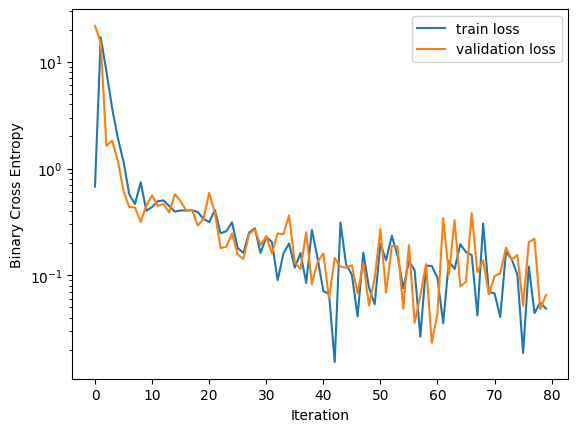

In [ ]:
plt.figure()
plt.semilogy(train_loss, label = 'train loss')
plt.semilogy(val_loss, label = 'validation loss')
plt.xlabel('Iteration')
plt.ylabel('Binary Cross Entropy')
plt.legend()

## Model Evaluation

Need to define metric inside Module for it to be moved to GPU

In [ ]:
!pip install torchmetrics #takes long time to run, so I will create accuracy and confusion matrix functions

In [ ]:
from torchmetrics import Accuracy, ConfusionMatrix

In [ ]:
class AccuracyScore(torch.nn.Module):
    def __init__(self, n_classes=2):
        super().__init__()
        if n_classes == 2:
            self.Metric = Accuracy(task='binary', num_classes=n_classes)
        else:
            self.Metric = Accuracy(task='multiclass', num_classes=n_classes)

    def forward(self, y_true, y_pred):
        y_pred = torch.squeeze(y_pred)
        score = self.Metric(y_true, y_pred)
        return score

class ConfusionMatrix(torch.nn.Module):
    def __init__(self, n_classes=2):
        super().__init__()
        if n_classes == 2:
            self.Metric = ConfusionMatrix(task='binary', num_classes=n_classes)
        else:
            self.Metric = ConfusionMatrix(task='multiclass', num_classes=n_classes)

    def forward(self, y_true, y_pred):
        y_pred = torch.squeeze(y_pred)
        score = self.Metric(y_true, y_pred)

2 x 2 Confusion Matrix showing predictions

In [ ]:
test_dl = iter(DL(test_ds, batch_size = batch_size, shuffle = True, pin_memory = True))

In [ ]:
# confusion matrix where rows correspond to targets and columns correspond to predictions
def confusion_matrix(y_pred, y_true, n_classes=2):
    conf_mat = torch.zeros((n_classes, n_classes))
    #conf_mat = conf_mat.to(device)
    if n_classes == 2:
        y_labels = torch.round(torch.squeeze(y_pred, -1))
    else:
        y_labels = torch.argmax(y_pred, dim=1)
    for i in range(len(y_true)):
        conf_mat[y_true[i]][y_labels[i].int()] += 1
    return conf_mat

In [ ]:
test_batch, test_labels = next(test_dl)
test_batch = test_batch.to(device)
test_labels = test_labels.to(device)
test_pred = torch.nn.functional.sigmoid(convnet(test_batch))
print(confusion_matrix(test_pred, test_labels)) # With more training iterations, there seems to be increased model bias towards predicting pneumonia

tensor([[ 1.,  9.],
        [ 0., 22.]], device='cuda:0')


Accuracy Report

In [ ]:
def binary_accuracy(y_pred, y_true):
    y_labels = torch.round(torch.squeeze(y_pred, -1))
    diff = y_labels - y_true
    count = 0
    for num in diff:
        if num == 0:
            count += 1
    return count / len(diff)

In [ ]:
test_dl = iter(DL(test_ds, batch_size = batch_size, shuffle = True, pin_memory = True))

test_loss = []
accuracy_scores = []
for i in range(len(test_dl)):
    test_batch, test_labels = next(test_dl)
    test_batch = test_batch.to(device)
    test_labels = test_labels.to(device)

    test_pred = convnet(test_batch)
    loss = criterion(torch.squeeze(test_pred, -1), test_labels.float())
    test_loss.append(loss.item())
    acc = binary_accuracy(torch.nn.functional.sigmoid(test_pred), test_labels)
    accuracy_scores.append(acc)

In [ ]:
mean_loss = np.mean(test_loss)
std_error_loss = np.std(test_loss)
min_loss = np.min(test_loss)
mean_acc = np.mean(accuracy_scores)
std_error_acc = np.std(accuracy_scores)
max_acc = np.max(accuracy_scores)

print(f'Best estimate loss: {mean_loss} +- {std_error_loss}')
print(f'Lowest loss: {min_loss}')
print(f'Best estimate accuracy: {mean_acc} +- {std_error_acc}')
print(f'Best accuracy: {max_acc}')

Best estimate loss: 0.8442280322313309 +- 0.2355231755949167
Lowest loss: 0.4625024199485779
Best estimate accuracy: 0.7328125 +- 0.08470710105268625
Best accuracy: 0.875


###**Results**

<u>40 training epochs:</u>
*   avg test acuracy: 0.7703
*   best accuracy: 0.9063

<u>50 training epochs:</u>
*   avg test accuracy: 0.7859
*   best accuracy: 0.9375  

<u>80 training epochs:</u>
*   avg test accuracy: 0.75
*   best accuracy: 0.875

<u>125 training epochs:</u>
*   avg test accuracy: 0.7
*   best accuracy: 0.8438

Notes: Testing accuracy seemed to decrease with increased model iterations, indicating overfitting. What is troubling is that generalization error is not being captured by validation loss. Loss plots in all four tests showed healthy decline in training and validation loss over epochs with no rebound in validation loss, which should correlate with superior model performance on test set. This likely indicates that the training and validation sets are very different or not representative of the test set. There is something wrong with the data or how it is being loaded. Validation loss was also sometimes lower than training loss despite no regularization being implemented. One notable observation from examining the confusion matrices is that the model consistently demonstrated high power in the testing set, correctly detecting pneumonia in x-ray images that were in fact from pneumonia cases; however, the probability of a (type II(false positive) error) increased. This leads me to believe that the dataset imbalance observed with the training set having much more pneumonia x-ray images than normal x-ray images is causing problems for model performance.


<u>Next steps:</u>
* Image augmentation techniques to diversify training set, in particular to generate more normal x-ray images
* Regularization or Batch Normalization in model
* Look at F1 score to capture poor precision of model
* Re-examine data, use higher validation split (0.7, 0.3)














# Image Augmentation

In order for augmentation to be effective, I must consider domain knowledge. The synthesized images must be sensible given the x-ray imagery context. I have summarized notes from some papers I found on image augmentation with chest x-ray images.

Elgendi M, Nasir MU, Tang Q, et al. The Effectiveness of Image Augmentation in Deep Learning Networks for Detecting COVID-19: A Geometric Transformation Perspective. *Front Med (Lausanne)*. 2021;8:629134. Published 2021 Mar 1. doi:<u>10.3389/fmed.2021.629134</u>
*   No Flips as this generates unrealistic images that confuse model
*   No shearing as this also generates x-ray images not seen clinically
*   Small amount of rotation and translation is acceptable to account for differences in patient position or x-ray device position

Monshi MMA, Poon J, Chung V, Monshi FM. CovidXrayNet: Optimizing data augmentation and CNN hyperparameters for improved COVID-19 detection from CXR. *Comput Biol Med*. 2021;133:104375. doi:<u>10.1016/j.compbiomed.2021.104375</u>
Based on empirical evaluation and consulting radiologists
*   Ideal image size around 480x480 for the COVID chest x-ray dataset they used
*   Random Rotation up to 20° at 0.75 probability
*   Zooming by 1.2 at 0.75 probability
*   Brightness increase by 0.3
*   Warping by 0.2
*   Warping and brightening account for x-rays taken at different angles and in differently lit rooms.

Testing different transforms

In [ ]:
image, label = train_ds[5000]
print(image, label)

tensor([[[0.0000e+00, 1.0569e-01, 8.5407e-01,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 1.0569e-01, 8.5407e-01,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 1.0569e-01, 8.5407e-01,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [1.2551e-02, 1.2587e-02, 9.8106e-04,  ..., 9.8102e-04,
          1.2587e-02, 1.2551e-02],
         [2.5659e-01, 2.7195e-02, 8.4975e-04,  ..., 8.4971e-04,
          2.7194e-02, 2.5659e-01],
         [2.2121e-02, 9.2868e-03, 2.7043e-04,  ..., 2.7042e-04,
          9.2867e-03, 2.2121e-02]],

        [[0.0000e+00, 1.0569e-01, 8.5407e-01,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 1.0569e-01, 8.5407e-01,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 1.0569e-01, 8.5407e-01,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [1.2551e-02, 1.2587e-02, 9.8106e-04,  ..., 9.8102e-04,
          1.258

In [ ]:
aug1 = ttv2.RandomRotation(20)
aug2 = ttv2.RandomAffine(0, translate = (0.15, 0.15), scale = (1, 1.2))
aug3 = ttv2.RandomAdjustSharpness(sharpness_factor=0.8, p=1)
aug4 = ttv2.RandomPerspective(distortion_scale = 0.2, p=1)
aug5 = ttv2.ColorJitter(brightness = (0.8, 1.3))
#aug6 = ttv2.ElasticTransform(alpha = 50, sigma = 7) Potentially too much distortion in images

augs = [aug1, aug2, aug3, aug4, aug5]

Text(0.5, 1.0, 'base')

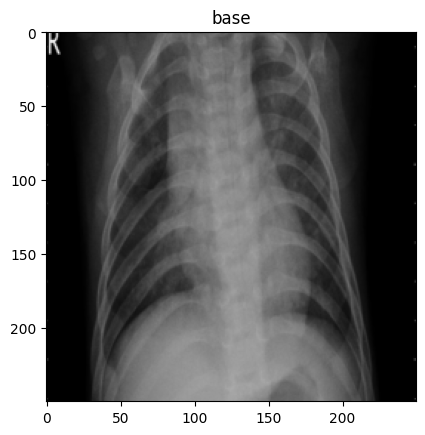

In [ ]:
# Unaltered image
plt.imshow(image.permute(1, 2, 0))
plt.title('base')

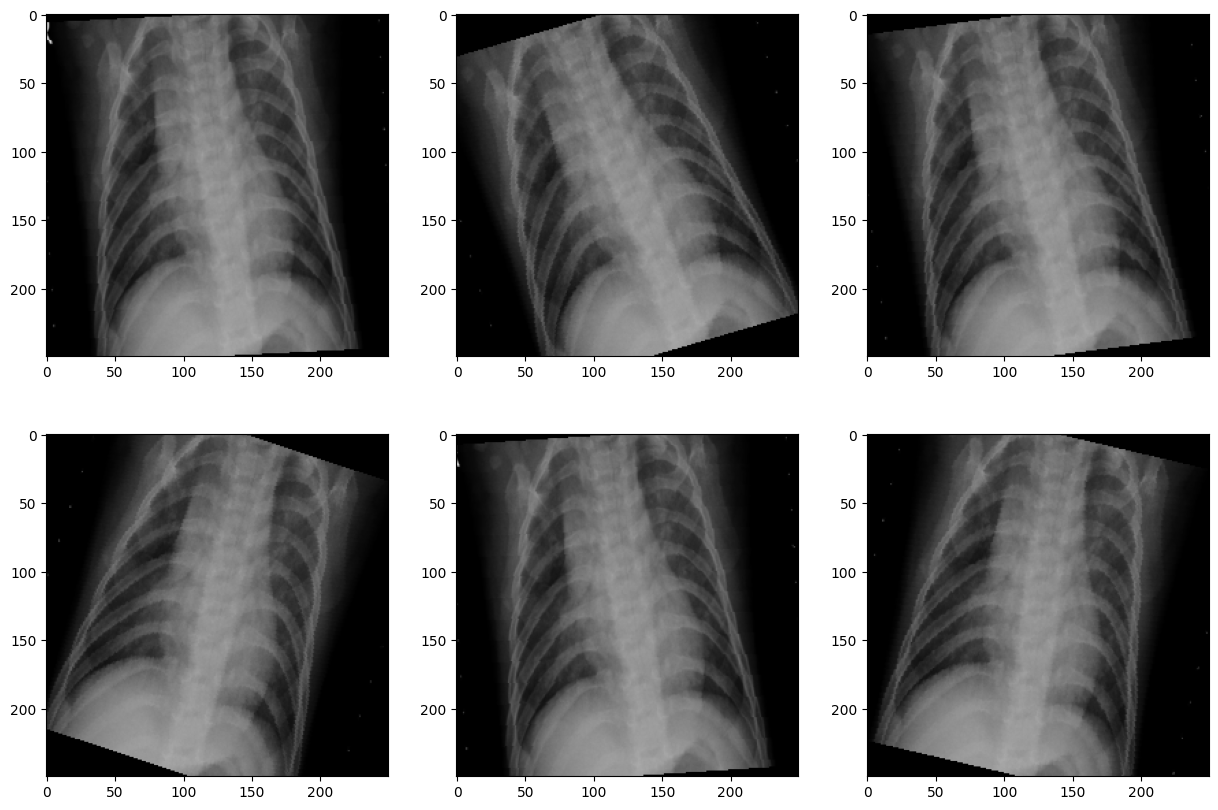

In [ ]:
# Rotation
plt.figure(figsize = (15, 10))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    img = augs[0].forward(image)
    plt.imshow(img.permute(1, 2, 0))

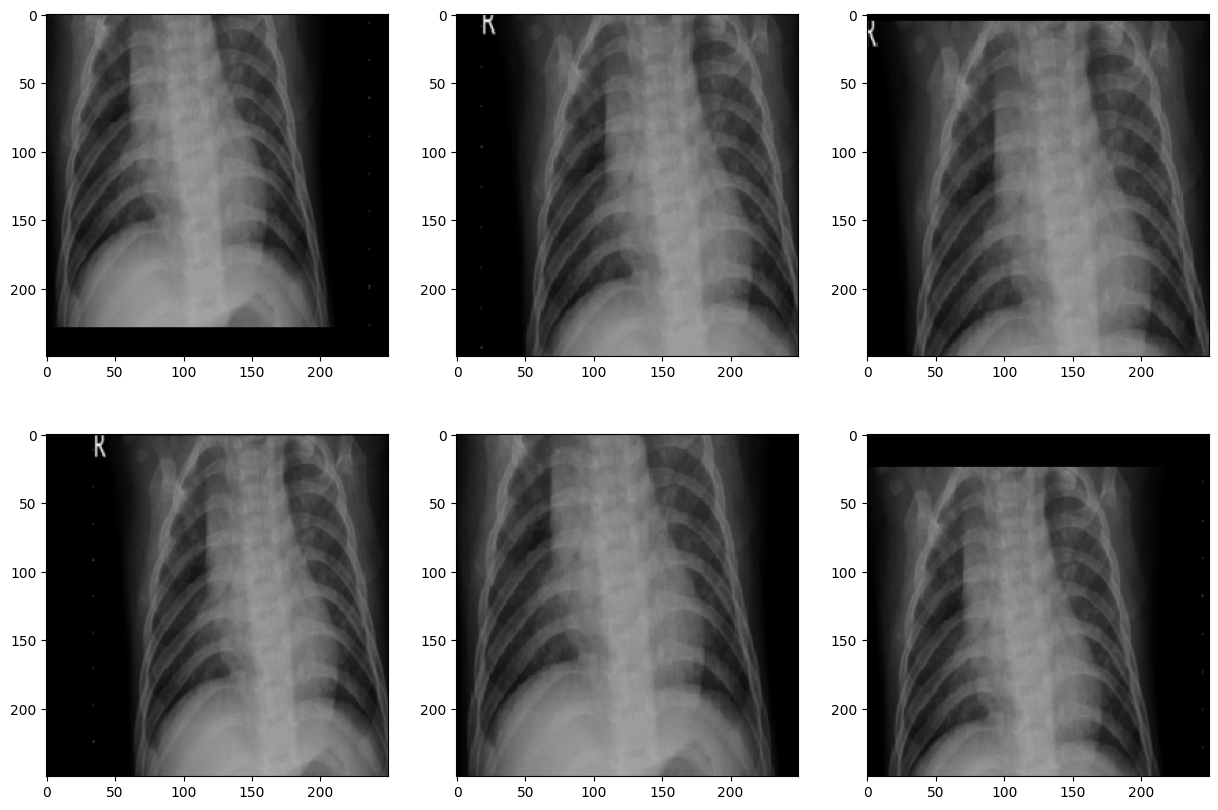

In [ ]:
# Scaling and Translation
plt.figure(figsize = (15, 10))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    img = augs[1].forward(image)
    plt.imshow(img.permute(1, 2, 0))

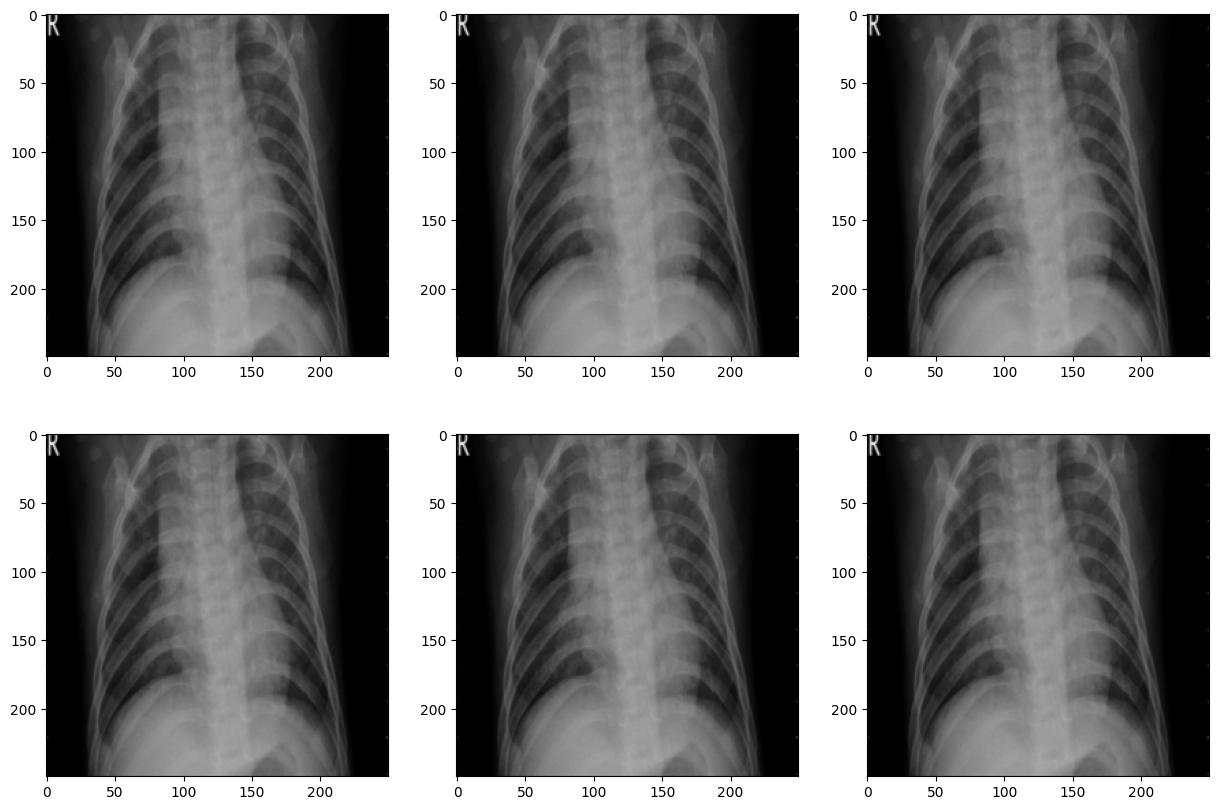

In [ ]:
# Sharpness
plt.figure(figsize = (15, 10))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    img = augs[2].forward(image)
    plt.imshow(img.permute(1, 2, 0))

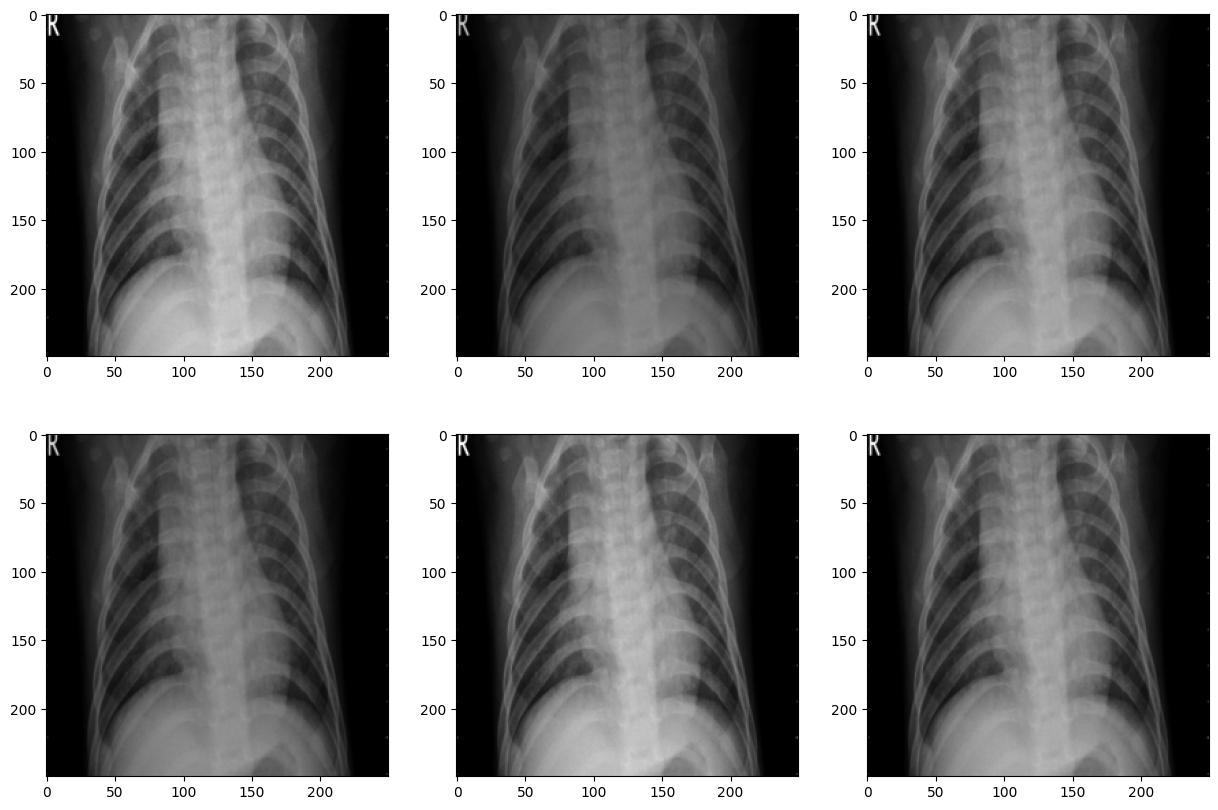

In [ ]:
# Brightness
plt.figure(figsize = (15, 10))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    img = augs[4].forward(image)
    plt.imshow(img.permute(1, 2, 0))

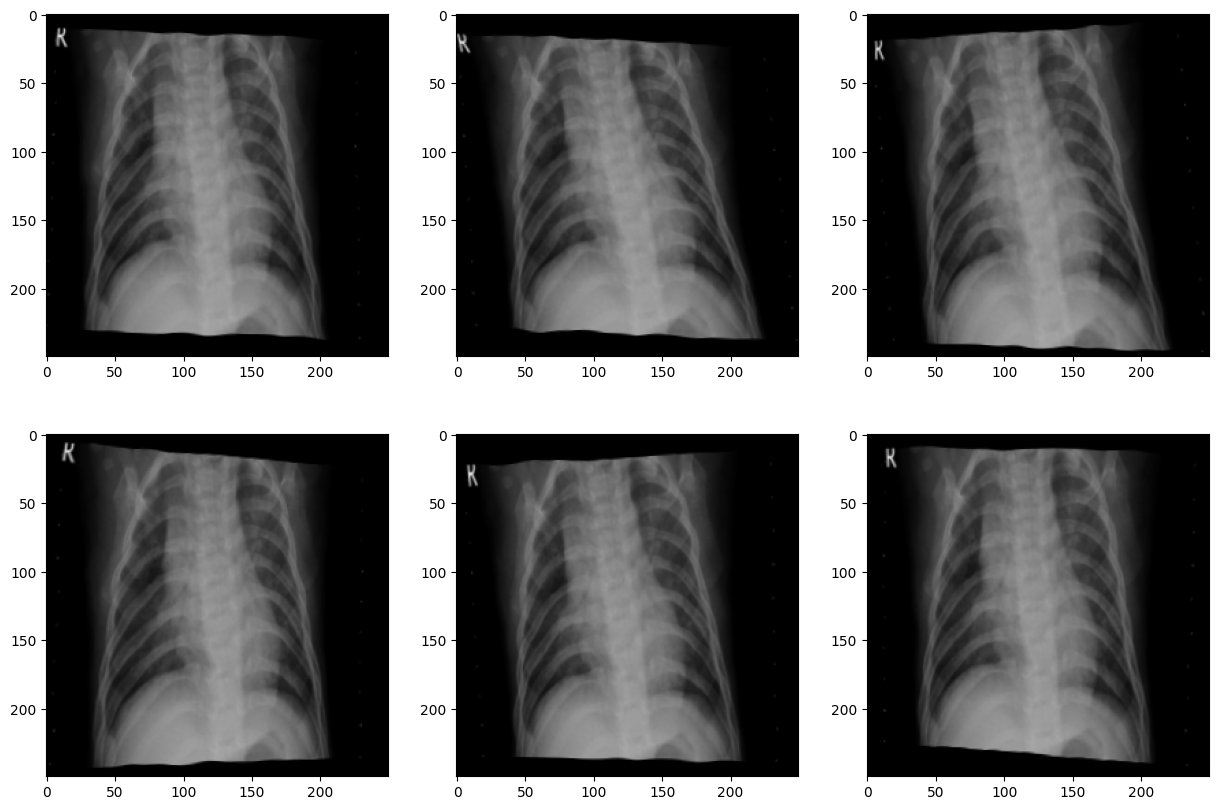

In [ ]:
# Warping
plt.figure(figsize = (15, 10))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    img = augs[3].forward(image)
    plt.imshow(img.permute(1, 2, 0))

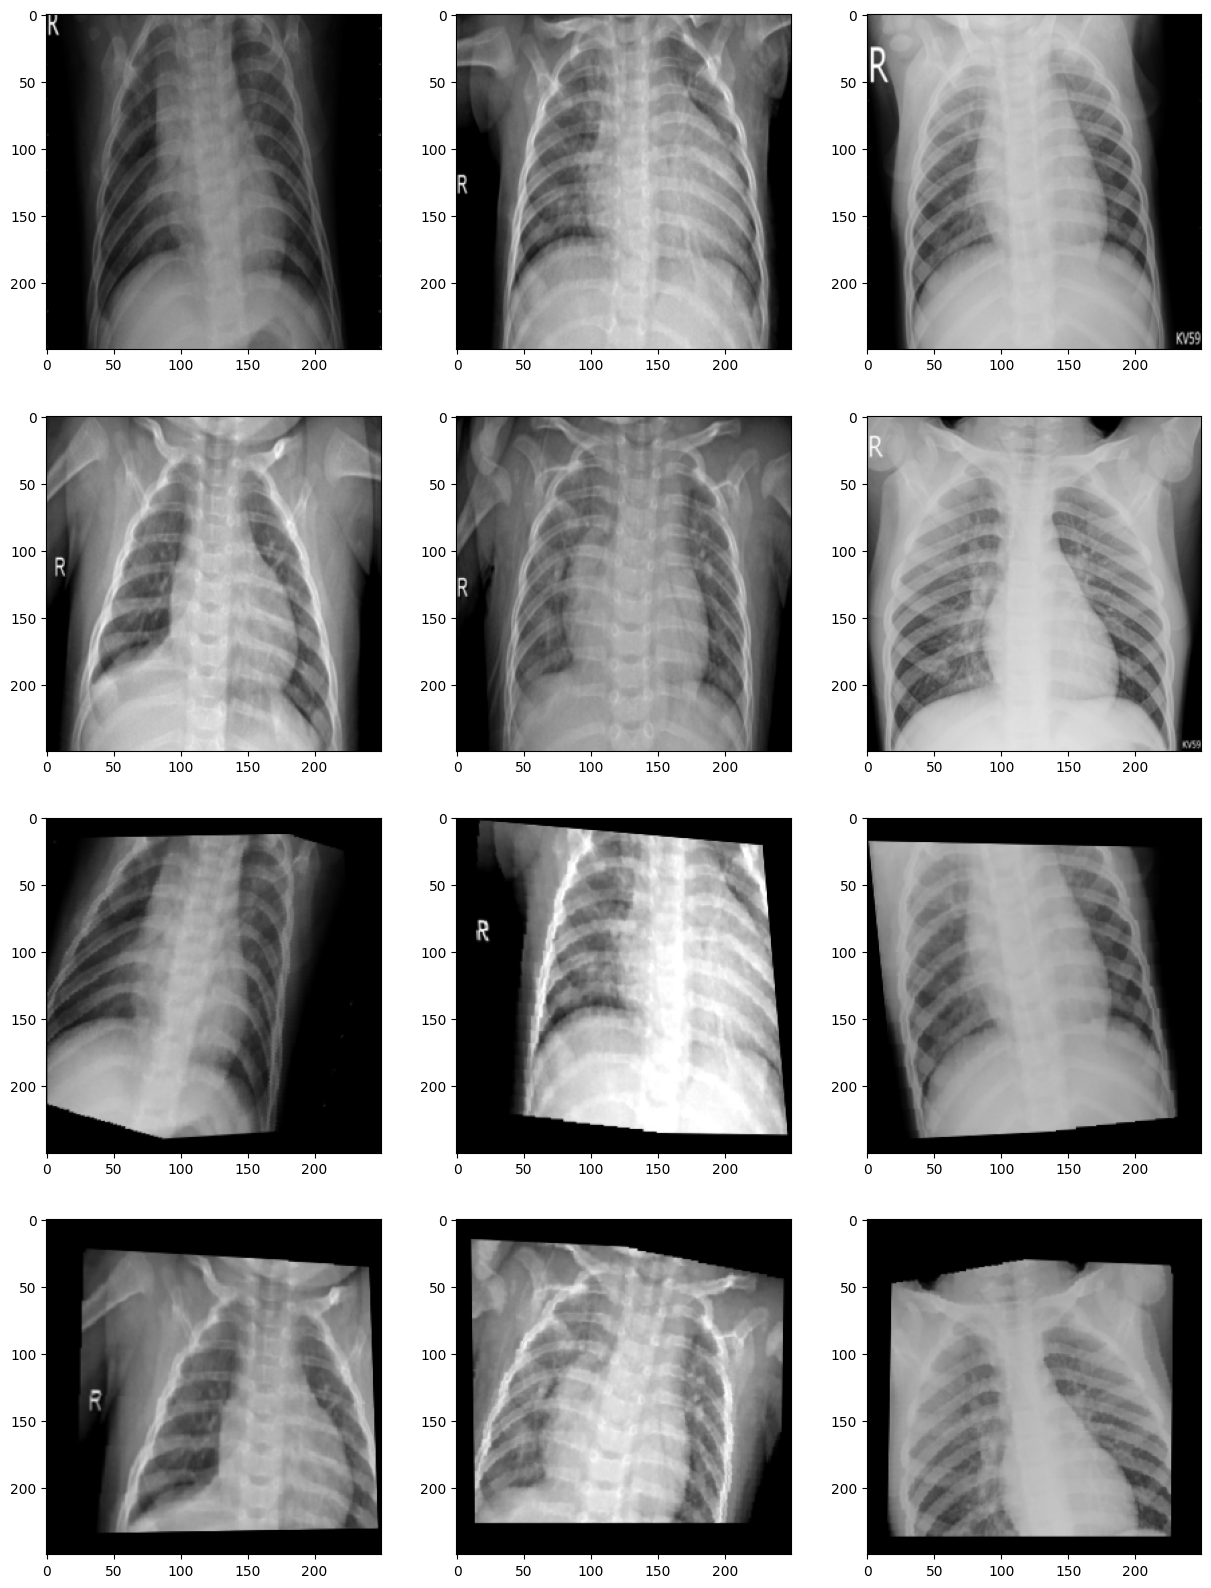

In [ ]:
# Composition of all transforms over batch of 6 images
images = torch.empty(6, 3, 250, 250)
labels = torch.empty(6, 1)
for i in range(5000, 5006):
    im, lab = train_ds[i]
    images[i - 5000] = im
    labels[i - 5000] = lab

composition = ttv2.Compose(augs)
plt.figure(figsize = (15, 20))
for i in range(6):
    plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].permute(1, 2, 0))

for i in range(6, 12):
    plt.subplot(4, 3, i + 1)
    img = composition(images[i - 6])
    plt.imshow(img.permute(1, 2, 0))

# Data loader with augmentation

Because we only want augmentation on the training set, we can either redistribute the images in the folder directly before using the ImageFolder class, add augmentation layers into the model that activate only during training phase, or pass the training images through augmentation functions before feeding to model

In [ ]:
augmentation = tt.Compose([ttv2.RandomApply([ttv2.RandomRotation(20)], p = 0.75),
                           ttv2.RandomApply([ttv2.RandomAffine(0, translate = (0.15, 0.15), scale = (1, 1.2))], p = 0.75),
                           ttv2.RandomAdjustSharpness(sharpness_factor=0.8, p=0.9),
                           ttv2.ColorJitter(brightness = (0.8, 1.3)),
                           ttv2.RandomPerspective(distortion_scale = 0.2, p=1)])

In [ ]:
# move all validation images to training folder
normal_val = os.listdir(os.path.join(base_dir, 'val/NORMAL'))
pneumonia_val = os.listdir(os.path.join(base_dir, 'val/PNEUMONIA'))

for file_path in normal_val:
    shutil.move(os.path.join(base_dir, 'val/NORMAL', file_path), os.path.join(base_dir, 'train/NORMAL'))
for file_path in pneumonia_val:
    shutil.move(os.path.join(base_dir, 'val/PNEUMONIA', file_path), os.path.join(base_dir, 'train/PNEUMONIA'))

In [ ]:
# function to redistribute images to validation folder
# assumes validation folder exists and train and validation folder have subfolders for each class
# don't need to run right now
def redistr_dir(base, classes, val_prop = 0.3):
    for clas in classes:
        img_paths = os.listdir(os.path.join(base, 'train/', clas))
        val_paths = random.sample(img_paths, k=int(val_prop * len(img_paths)))
        for file_path in val_paths:
            shutil.move(os.path.join(base, 'train/', clas, file_path), os.path.join(base, 'val/', clas))

redistr_dir(base_dir, ['NORMAL', 'PNEUMONIA'])

In [ ]:
# split dataset into training and validation sets
train_ds = ImageFolder(os.path.join(base_dir, 'train'), transform = tt.Compose([tt.ToTensor(),
                                                                               tt.Resize((250, 250))]))
train_set, val_set = torch.utils.data.random_split(train_ds, [0.7, 0.3])

In [ ]:
# get all normal x-ray images from training set
images = train_ds.imgs # convert training set to
inds = [ind for ind in train_set.indices if images[ind][1] == 0]
normal_set = torch.utils.data.Subset(train_ds, inds)
print(len(normal_set))

942


In [ ]:
# takes about 3 minutes to generate all images
# generate 2048 augmented images from existing normal chest x-rays
normal_dl = iter(DL(normal_set, batch_size = 1, shuffle = True))
labels = torch.zeros(2048, dtype = torch.int64) # tried dtype int64
imgs = torch.empty(2048, 3, 250, 250)
for i in range(2048):
    try:
        imgs[i] = augmentation(next(normal_dl)[0])
    except StopIteration:
        normal_dl = iter(DL(normal_set, batch_size = 1, shuffle=True))
        imgs[i] = augmentation(next(normal_dl)[0])

In [ ]:
# custom dataset that allows image tensor input features and scalar target variable
class ImageDataset(Dataset):
    def __init__(self, images, labels, transform = None, target_transform = None):
        super().__init__()
        self.imgs = images
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, ind):
        img = self.imgs[ind]
        label = self.labels[ind].item()
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            label = self.target_transform(label)
        return img, label

extra_train = ImageDataset(imgs, labels)

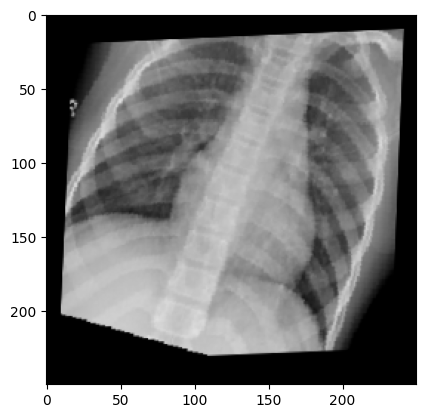

In [ ]:
plt.imshow(extra_train[500][0].permute(1, 2, 0))

In [ ]:
full_train = torch.utils.data.ConcatDataset([train_set, extra_train])
print(len(train_set))
print(len(extra_train))
print(len(full_train))

3663
2048
5711


In [ ]:
batch_size = 32
test_ds = ImageFolder(os.path.join(base_dir, 'test'), transform = tt.Compose([tt.ToTensor(),
                                                                             tt.Resize((250, 250))]))

# create dataloaders
train_dl = iter(DL(full_train, batch_size = batch_size, shuffle = True, pin_memory = True))
val_dl = iter(DL(val_set, batch_size = batch_size, shuffle=True, pin_memory=True))
test_dl = iter(DL(test_ds, batch_size = batch_size, shuffle = True, pin_memory = True))

# Same Convnet

In [ ]:
class ConvModel(torch.nn.Module):
    def __init__(self, classes=2):
        super().__init__()
        self.conv1 = torch.nn.Sequential(torch.nn.Conv2d(3, 32, (3, 3), padding = 'same'),
                                         torch.nn.ReLU(),
                                         torch.nn.MaxPool2d((2, 2), stride=2)) # output shape = (bs, 32, 125, 125)
        self.conv1[0].weight = torch.nn.init.kaiming_normal_(self.conv1[0].weight, nonlinearity = 'relu')
        self.conv2 = torch.nn.Sequential(torch.nn.Conv2d(32, 32, (3, 3), padding='same'),
                                         torch.nn.ReLU(),
                                         torch.nn.MaxPool2d((2, 2), stride=2)) # output shape = (bs, 32, 62, 62)
        self.conv2[0].weight = torch.nn.init.kaiming_normal_(self.conv2[0].weight, nonlinearity = 'relu')
        self.conv3 = torch.nn.Sequential(torch.nn.Conv2d(32, 64, (3, 3), padding='same'),
                                         torch.nn.ReLU(),
                                         torch.nn.MaxPool2d((2, 2), stride=2)) # output shape = (bs, 64, 31, 31)
        self.conv3[0].weight = torch.nn.init.kaiming_normal_(self.conv3[0].weight, nonlinearity = 'relu')
        self.flatten = torch.nn.Flatten()
        self.dense = torch.nn.Linear(64 * 31 * 31, 128) # max pool cuts image size by half each time
        self.dense.weight = torch.nn.init.kaiming_normal_(self.dense.weight, nonlinearity = 'relu')
        self.output = torch.nn.Linear(128, 1)
        self.output.weight = torch.nn.init.xavier_normal_(self.output.weight)


    def forward(self, x):
        y = self.conv1(x)
        y = self.conv2(y)
        y = self.conv3(y)
        y = self.flatten(y)
        y = torch.nn.functional.relu(self.dense(y))
        y = self.output(y)
        return y

    def reset_weights(self):
        self.conv1[0].weight = torch.nn.init.kaiming_normal_(self.conv1[0].weight, nonlinearity = 'relu')
        self.conv2[0].weight = torch.nn.init.kaiming_normal_(self.conv2[0].weight, nonlinearity = 'relu')
        self.conv3[0].weight = torch.nn.init.kaiming_normal_(self.conv3[0].weight, nonlinearity = 'relu')
        self.dense.reset_parameters()
        self.dense.weight = torch.nn.init.kaiming_normal_(self.dense.weight, nonlinearity = 'relu')
        self.output.reset_parameters()
        self.output.weight = torch.nn.init.xavier_normal_(self.output.weight)


convnet = ConvModel()
convnet.to(device)
summary(convnet, input_size = (3, 250, 250))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 250, 250]             896
              ReLU-2         [-1, 32, 250, 250]               0
         MaxPool2d-3         [-1, 32, 125, 125]               0
            Conv2d-4         [-1, 32, 125, 125]           9,248
              ReLU-5         [-1, 32, 125, 125]               0
         MaxPool2d-6           [-1, 32, 62, 62]               0
            Conv2d-7           [-1, 64, 62, 62]          18,496
              ReLU-8           [-1, 64, 62, 62]               0
         MaxPool2d-9           [-1, 64, 31, 31]               0
          Flatten-10                [-1, 61504]               0
           Linear-11                  [-1, 128]       7,872,640
           Linear-12                    [-1, 1]             129
Total params: 7,901,409
Trainable params: 7,901,409
Non-trainable params: 0
---------------------------

## Training Loop

In [ ]:
free, total = torch.cuda.mem_get_info()
print("Percent Memory Available:", free / total * 100)

Percent Memory Available: 87.96853078842707


In [ ]:
convnet.reset_weights()
epochs = 125
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(convnet.parameters())
train_loss = []
val_loss = []

for n in range(epochs):
    try:
        image_batch, label_batch = next(train_dl)
        val_image_batch, val_label_batch = next(val_dl)
    except StopIteration:
        train_dl = iter(DL(full_train, batch_size = batch_size, shuffle = True, pin_memory = True))
        val_dl = iter(DL(val_set, batch_size = batch_size, shuffle=True, pin_memory = True))
        image_batch, label_batch = next(train_dl)
        val_image_batch, val_label_batch = next(val_dl)
    finally:
        # images are augmented before training
        # image_batch = augmentation(image_batch)
        image_batch = image_batch.to(device)
        label_batch = label_batch.to(device)

        # forward pass
        y_pred = convnet(image_batch)
        loss = criterion(torch.squeeze(y_pred, -1), label_batch.float())

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

        # validation
        val_image_batch = val_image_batch.to(device)
        val_label_batch = val_label_batch.to(device)

        y_pred = convnet(val_image_batch)
        loss = criterion(torch.squeeze(y_pred, -1), val_label_batch.float())
        val_loss.append(loss.item())

    if (n + 1) % 5 == 0:
        print(f'Epoch {n + 1}    loss:{train_loss[-1]:.4f}    val loss: {val_loss[-1]:.4f}')

Epoch 5    loss:2.7021    val loss: 1.0439
Epoch 10    loss:0.5672    val loss: 0.5292
Epoch 15    loss:0.3551    val loss: 0.4109
Epoch 20    loss:0.4194    val loss: 1.4367
Epoch 25    loss:0.4378    val loss: 0.5028
Epoch 30    loss:0.2666    val loss: 0.4542
Epoch 35    loss:0.1793    val loss: 0.3737
Epoch 40    loss:0.1782    val loss: 0.2824
Epoch 45    loss:0.1942    val loss: 0.2924
Epoch 50    loss:0.1477    val loss: 0.3145
Epoch 55    loss:0.1637    val loss: 0.1506
Epoch 60    loss:0.1227    val loss: 0.1684
Epoch 65    loss:0.1260    val loss: 0.2644
Epoch 70    loss:0.0450    val loss: 0.0780
Epoch 75    loss:0.0898    val loss: 0.1200
Epoch 80    loss:0.0761    val loss: 0.1637
Epoch 85    loss:0.0332    val loss: 0.2045
Epoch 90    loss:0.0591    val loss: 0.1980
Epoch 95    loss:0.0782    val loss: 0.3804
Epoch 100    loss:0.3381    val loss: 0.2025
Epoch 105    loss:0.1055    val loss: 0.4321
Epoch 110    loss:0.5103    val loss: 0.3713
Epoch 115    loss:0.0729    va

In [ ]:
len(train_dl)

179

Loss plots

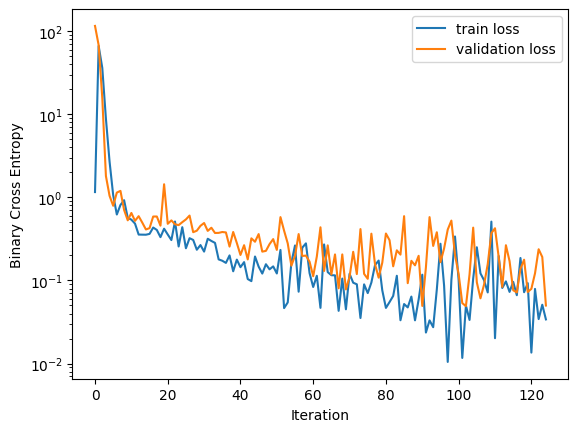

In [ ]:
plt.figure()
plt.semilogy(train_loss, label = 'train loss')
plt.semilogy(val_loss, label = 'validation loss')
plt.xlabel('Iteration')
plt.ylabel('Binary Cross Entropy')
plt.legend()

## Evaluation

In [ ]:
test_dl = iter(DL(test_ds, batch_size = batch_size, shuffle = True, pin_memory = True))

In [ ]:
test_batch, test_labels = next(test_dl)
test_batch = test_batch.to(device)
test_labels = test_labels.to(device)
test_pred = torch.nn.functional.sigmoid(convnet(test_batch))
print(confusion_matrix(test_pred, test_labels)) # With more training iterations, there seems to be increased model bias towards predicting pneumonia

tensor([[ 8.,  6.],
        [ 0., 18.]], device='cuda:0')


F1 score function

In [ ]:
# TP / (TP + FN) sensitivity fraction of pneumonia cases retrieved
def recall(y_pred, y_true):
    y_labels = torch.round(torch.squeeze(y_pred))
    tp = 0
    fn = 0
    for i in range(len(y_true)):
        if y_labels[i] == 1 and y_true[i] == 1:
            tp += 1
        elif y_labels[i] == 0 and y_true[i] == 1:
            fn += 1
    return tp / (tp + fn)

# TP / (TP + FP) # fraction of pneumonia detections that were correct
def precision(y_pred, y_true):
    y_labels = torch.round(torch.squeeze(y_pred))
    tp = 0
    fp = 0
    for i in range(len(y_true)):
        if y_labels[i] == 1 and y_true[i] == 1:
            tp += 1
        elif y_labels[i] == 1 and y_true[i] == 0:
            fp += 1
    return tp / (tp + fp)

# harmonic mean of precision and recall
def f1score(y_pred, y_true):
    recall_score = recall(y_pred, y_true)
    precision_score = precision(y_pred, y_true)
    f1_score = 2 * precision_score * recall_score / (precision_score + recall_score)
    return f1_score

In [ ]:
test_dl = iter(DL(test_ds, batch_size = batch_size, shuffle = True, pin_memory = True))

test_loss = []
accuracy_scores = []
prec_scores = []
rec_scores = []
f1_scores = []
for i in range(len(test_dl)):
    test_batch, test_labels = next(test_dl)
    test_batch = test_batch.to(device)
    test_labels = test_labels.to(device)

    test_pred = convnet(test_batch)
    loss = criterion(torch.squeeze(test_pred, -1), test_labels.float())
    test_loss.append(loss.item())

    acc = binary_accuracy(torch.nn.functional.sigmoid(test_pred), test_labels)
    prec = precision(torch.nn.functional.sigmoid(test_pred), test_labels)
    rec = recall(torch.nn.functional.sigmoid(test_pred), test_labels)
    f1_score = f1score(torch.nn.functional.sigmoid(test_pred), test_labels)
    accuracy_scores.append(acc)
    prec_scores.append(prec)
    rec_scores.append(rec)
    f1_scores.append(f1_score)

In [ ]:
mean_loss = np.mean(test_loss)
std_loss = np.std(test_loss)
min_loss = np.min(test_loss)
mean_acc = np.mean(accuracy_scores)
std_acc = np.std(accuracy_scores)
max_acc = np.max(accuracy_scores)
mean_prec = np.mean(prec_scores)
std_prec = np.std(prec_scores)
max_prec = np.max(prec_scores)
mean_rec = np.mean(rec_scores)
std_rec = np.std(rec_scores)
max_rec = np.max(rec_scores)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)
max_f1 = np.max(f1_scores)

print(f'Best estimate loss: {mean_loss} +- {std_loss}')
print(f'Lowest loss: {min_loss}')
print(f'Best estimate accuracy: {mean_acc} +- {std_acc}')
print(f'Best accuracy: {max_acc}')
print(f'Best estimate precision: {mean_prec} +- {std_prec}')
print(f'Best precision: {max_prec}')
print(f'Best estimate recall: {mean_rec} +- {std_rec}')
print(f'Best recall: {max_rec}')
print(f'Best estimate f1-score: {mean_f1} +- {std_f1}')
print(f'Best f1-score: {max_f1}')

Best estimate loss: 0.6038729049265384 +- 0.21059609798792833
Lowest loss: 0.15571485459804535
Best estimate accuracy: 0.7734375 +- 0.07773339352395468
Best accuracy: 0.96875
Best estimate precision: 0.7326444999712519 +- 0.09418973396403077
Best precision: 0.967741935483871
Best estimate recall: 0.9897321428571428 +- 0.025627661495543422
Best recall: 1.0
Best estimate f1-score: 0.8386815463572999 +- 0.06356736810236148
Best f1-score: 0.9836065573770492


### **Results**
<u>50 training epochs</u>


*   Avg accuracy: 0.6953&emsp;&emsp;&emsp;Best accuracy: 0.8125
*   Avg precision: 0.6730&emsp;&emsp;&emsp;Best precision: 0.7857
*   Avg recall: 0.9964&emsp;&emsp;&emsp;&emsp;&ensp;Best recall: 1.0
*   Avg f1-score: 0.8004&emsp;&emsp;&emsp;&nbsp;Best f1-score: 0.88

<u>80 training epochs</u>


*   Avg accuracy: 0.7859&emsp;&emsp;&emsp;Best accuracy: 0.875
*   Avg precision: 0.7586&emsp;&emsp;&emsp;Best precision: 0.92
*   Avg recall: 0.9594&emsp;&emsp;&emsp;&emsp;&ensp;Best recall: 1.0
*   Avg f1-score: 0.8443&emsp;&emsp;&emsp;&nbsp;Best f1-score: 0.926

<u>125 training epochs</u>

*   Avg accuracy: 0.7734&emsp;&emsp;&emsp;Best accuracy: 0.9688
*   Avg precision: 0.7326&emsp;&emsp;&emsp;Best precision: 0.9677
*   Avg recall: 0.9897&emsp;&emsp;&emsp;&emsp;&ensp;Best recall: 1.0
*   Avg f1-score: 0.8387&emsp;&emsp;&emsp;&nbsp;Best f1-score: 0.9836





# Regularized Convnet

Implemented batch normalization and dropout layers

In [ ]:
class RegularizedConvModel(torch.nn.Module):
    def __init__(self, classes=2):
        super().__init__()
        self.conv1 = torch.nn.Sequential(torch.nn.Conv2d(3, 32, (3, 3), padding = 'same', bias = False),
                                         torch.nn.BatchNorm2d(32),
                                         torch.nn.ReLU(),
                                         torch.nn.MaxPool2d((2, 2), stride=2)) # output shape = (bs, 32, 125, 125)
        self.conv1[0].weight = torch.nn.init.kaiming_normal_(self.conv1[0].weight, nonlinearity = 'relu')
        self.conv2 = torch.nn.Sequential(torch.nn.Conv2d(32, 32, (3, 3), padding='same', bias = False),
                                         torch.nn.BatchNorm2d(32),
                                         torch.nn.ReLU(),
                                         torch.nn.MaxPool2d((2, 2), stride=2)) # output shape = (bs, 32, 62, 62)
        self.conv2[0].weight = torch.nn.init.kaiming_normal_(self.conv2[0].weight, nonlinearity = 'relu')
        self.conv3 = torch.nn.Sequential(torch.nn.Conv2d(32, 64, (3, 3), padding='same', bias = False),
                                         torch.nn.BatchNorm2d(64),
                                         torch.nn.ReLU(),
                                         torch.nn.MaxPool2d((2, 2), stride=2)) # output shape = (bs, 64, 31, 31)
        self.conv3[0].weight = torch.nn.init.kaiming_normal_(self.conv3[0].weight, nonlinearity = 'relu')
        self.flatten = torch.nn.Flatten()
        self.dense = torch.nn.Linear(64 * 31 * 31, 128) # max pool cuts image size by half each time
        self.dense.weight = torch.nn.init.kaiming_normal_(self.dense.weight, nonlinearity = 'relu')
        self.dropout = torch.nn.Dropout(0.25)
        self.output = torch.nn.Linear(128, 1)
        self.output.weight = torch.nn.init.xavier_normal_(self.output.weight)
        self.augment = ttv2.Compose([ttv2.RandomAffine(20, translate = (0.15, 0.15), scale = (1, 1.2)),
                                     ttv2.RandomAdjustSharpness(sharpness_factor=0.8, p=1),
                                     ttv2.ColorJitter(brightness = (0.8, 1.3)),
                                     ttv2.RandomPerspective(distortion_scale = 0.2, p=1),
                                     ttv2.ElasticTransform(alpha = 60, sigma = 7)])

    def forward(self, x):
        y = self.conv1(x)
        y = self.conv2(y)
        y = self.conv3(y)
        y = self.flatten(y)
        y = torch.nn.functional.relu(self.dense(y))
        y = self.dropout(y)
        y = self.output(y)
        return y

    def reset_weights(self):
        self.conv1[0].weight = torch.nn.init.kaiming_normal_(self.conv1[0].weight, nonlinearity = 'relu')
        self.conv1[1].reset_parameters()
        self.conv2[0].weight = torch.nn.init.kaiming_normal_(self.conv2[0].weight, nonlinearity = 'relu')
        self.conv2[1].reset_parameters()
        self.conv3[0].weight = torch.nn.init.kaiming_normal_(self.conv3[0].weight, nonlinearity = 'relu')
        self.conv3[1].reset_parameters()
        self.dense.reset_parameters()
        self.dense.weight = torch.nn.init.kaiming_normal_(self.dense.weight, nonlinearity = 'relu')
        self.output.reset_parameters()
        self.output.weight = torch.nn.init.xavier_normal_(self.output.weight)


convnetreg = RegularizedConvModel()
convnetreg.to(device)
summary(convnetreg, input_size = (3, 250, 250))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 250, 250]             864
       BatchNorm2d-2         [-1, 32, 250, 250]              64
              ReLU-3         [-1, 32, 250, 250]               0
         MaxPool2d-4         [-1, 32, 125, 125]               0
            Conv2d-5         [-1, 32, 125, 125]           9,216
       BatchNorm2d-6         [-1, 32, 125, 125]              64
              ReLU-7         [-1, 32, 125, 125]               0
         MaxPool2d-8           [-1, 32, 62, 62]               0
            Conv2d-9           [-1, 64, 62, 62]          18,432
      BatchNorm2d-10           [-1, 64, 62, 62]             128
             ReLU-11           [-1, 64, 62, 62]               0
        MaxPool2d-12           [-1, 64, 31, 31]               0
          Flatten-13                [-1, 61504]               0
           Linear-14                  [

## Training Loop

In [ ]:
convnetreg.reset_weights()
epochs = 10
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(convnetreg.parameters())
train_loss = []
val_loss = []

for n in range(epochs):
    try:
        image_batch, label_batch = next(train_dl)
        val_image_batch, val_label_batch = next(val_dl)
    except StopIteration:
        train_dl = iter(DL(train_subset, batch_size = batch_size, shuffle = True, pin_memory = True))
        val_dl = iter(DL(val_subset, batch_size = batch_size, shuffle=True, pin_memory = True))
        image_batch, label_batch = next(train_dl)
        val_image_batch, val_label_batch = next(val_dl)
    finally:
        image_batch = image_batch.to(device)
        label_batch = label_batch.to(device)

        # forward pass
        convnetreg.train()
        y_pred = convnetreg(image_batch)
        print(y_pred)
        print(label_batch)
        loss = criterion(torch.squeeze(y_pred, -1), label_batch.float())

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

        # validation
        val_image_batch = val_image_batch.to(device)
        val_label_batch = val_label_batch.to(device)

        convnetreg.eval()
        y_pred = convnetreg(val_image_batch)
        loss = criterion(torch.squeeze(y_pred, -1), val_label_batch.float())
        val_loss.append(loss.item())

    if (n + 1) % 5 == 0:
        print(f'Epoch {n + 1}    loss:{train_loss[-1]:.4f}    val loss: {val_loss[-1]:.4f}')

tensor([[-0.6202],
        [-1.5640],
        [-0.0964],
        [-0.7004],
        [ 1.2184],
        [-0.8634],
        [ 1.8647],
        [-0.5350],
        [ 0.9351],
        [-0.7076],
        [-0.7797],
        [ 0.2604],
        [ 0.5626],
        [-0.7919],
        [-0.5452],
        [ 0.5069],
        [ 0.2679],
        [ 3.9580],
        [-0.4370],
        [ 0.7166],
        [ 1.6177],
        [ 1.2296],
        [ 0.6658],
        [-0.4913],
        [ 1.7314],
        [-0.5154],
        [-0.4699],
        [ 2.4967],
        [ 0.0709],
        [-1.4210],
        [ 1.4997],
        [-2.0190]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
tensor([[323.0759],
        [204.7814],
        [266.6890],
        [179.7017],
        [200.8994],
        [173.3029],
        [184.1630],
        [181.2036],
        [187.5247],
        [169.8386],
        [273.3321]

Loss plots

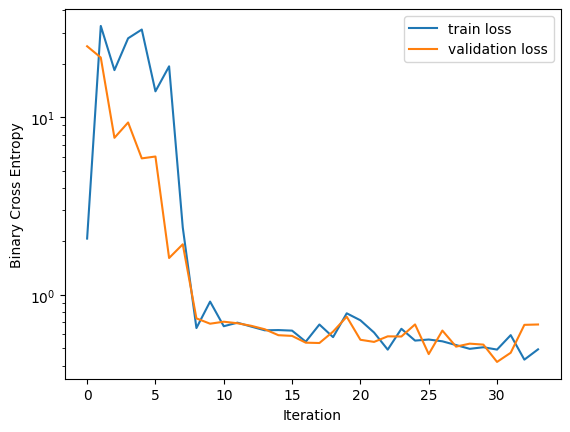

In [ ]:
plt.figure()
plt.semilogy(train_loss, label = 'train loss')
plt.semilogy(val_loss, label = 'validation loss')
plt.xlabel('Iteration')
plt.ylabel('Binary Cross Entropy')
plt.legend()

## Evaluation

In [ ]:
test_dl = iter(DL(test_ds, batch_size = batch_size, shuffle = True, pin_memory = True))

In [ ]:
test_batch, test_labels = next(test_dl)
test_batch = test_batch.to(device)
test_labels = test_labels.to(device)
test_pred = torch.nn.functional.sigmoid(convnetreg(test_batch))
print(confusion_matrix(test_pred, test_labels)) # With more training iterations, there seems to be increased model bias towards predicting pneumonia

tensor([[ 0., 13.],
        [ 0., 19.]])


In [ ]:
test_dl = iter(DL(test_ds, batch_size = batch_size, shuffle = True, pin_memory = True))

test_loss = []
accuracy_scores = []
prec_scores = []
rec_scores = []
f1_scores = []
convnetreg.eval()
for i in range(len(test_dl)):
    test_batch, test_labels = next(test_dl)
    test_batch = test_batch.to(device)
    test_labels = test_labels.to(device)

    test_pred = convnetreg(test_batch)
    loss = criterion(torch.squeeze(test_pred), test_labels.float())
    test_loss.append(loss.item())

    acc = binary_accuracy(torch.nn.functional.sigmoid(test_pred), test_labels)
    prec = precision(torch.nn.functional.sigmoid(test_pred), test_labels)
    rec = recall(torch.nn.functional.sigmoid(test_pred), test_labels)
    f1_score = f1score(torch.nn.functional.sigmoid(test_pred), test_labels)
    accuracy_scores.append(acc)
    prec_scores.append(prec)
    rec_scores.append(rec)
    f1_scores.append(f1_score)

In [ ]:
mean_loss = np.mean(test_loss)
std_loss = np.std(test_loss)
min_loss = np.min(test_loss)
mean_acc = np.mean(accuracy_scores)
std_acc = np.std(accuracy_scores)
max_acc = np.max(accuracy_scores)
mean_prec = np.mean(prec_scores)
std_prec = np.std(prec_scores)
max_prec = np.max(prec_scores)
mean_rec = np.mean(rec_scores)
std_rec = np.std(rec_scores)
max_rec = np.max(rec_scores)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)
max_f1 = np.max(f1_scores)

print(f'Best estimate loss: {mean_loss} +- {std_loss}')
print(f'Lowest loss: {min_loss}')
print(f'Best estimate accuracy: {mean_acc} +- {std_acc}')
print(f'Best accuracy: {max_acc}')
print(f'Best estimate precision: {mean_prec} +- {std_prec}')
print(f'Best precision: {max_prec}')
print(f'Best estimate recall: {mean_rec} +- {std_rec}')
print(f'Best recall: {max_rec}')
print(f'Best estimate f1-score: {mean_f1} +- {std_f1}')
print(f'Best f1-score: {max_f1}')

Best estimate loss: 0.6947980523109436 +- 0.10898013693566312
Lowest loss: 0.5183098316192627
Best estimate accuracy: 0.621875 +- 0.0837942979861995
Best accuracy: 0.75
Best estimate precision: 0.621875 +- 0.0837942979861995
Best precision: 0.75
Best estimate recall: 1.0 +- 0.0
Best recall: 1.0
Best estimate f1-score: 0.7635012161545965 +- 0.06513678453026614
Best f1-score: 0.8571428571428571


###**Results**
<u>50 training epochs</u>


*   Avg accuracy: 0.6359&emsp;&emsp;&emsp;Best accuracy: 0.8125
*   Avg precision: 0.6335&emsp;&emsp;&emsp;Best precision: 0.8125
*   Avg recall: 1.0&emsp;&emsp;&emsp;&emsp;&ensp;Best recall: 1.0
*   Avg f1-score: 0.7719&emsp;&emsp;&emsp;&nbsp;Best f1-score: 0.8966

<u>80 training epochs</u>


*   Avg accuracy: 0.7922&emsp;&emsp;&emsp;Best accuracy: 0.9375
*   Avg precision: 0.7610&emsp;&emsp;&emsp;Best precision: 0.9130
*   Avg recall: 0.9798&emsp;&emsp;&emsp;&emsp;&ensp;Best recall: 1.0
*   Avg f1-score: 0.8524&emsp;&emsp;&emsp;&nbsp;Best f1-score: 0.9545

<u>125 training epochs</u>

*   Avg accuracy: 0.7734&emsp;&emsp;&emsp;Best accuracy: 0.9688
*   Avg precision: 0.7326&emsp;&emsp;&emsp;Best precision: 0.9677
*   Avg recall: 0.9897&emsp;&emsp;&emsp;&emsp;&ensp;Best recall: 1.0
*   Avg f1-score: 0.8387&emsp;&emsp;&emsp;&nbsp;Best f1-score: 0.9836


# Transfer Learning ResNet50

In [ ]:
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights

In [ ]:
resnet = efficientnet_b4(weights='DEFAULT')
in_features = resnet.classifier[1].in_features
resnet = resnet.requires_grad_(False) # freeze model layers
resnet.classifier[1] = torch.nn.Linear(in_features, 1) # setting last layer for binary classification
resnet.to(device)
summary(resnet, input_size = (3, 250, 250))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 48, 125, 125]           1,296
       BatchNorm2d-2         [-1, 48, 125, 125]              96
              SiLU-3         [-1, 48, 125, 125]               0
            Conv2d-4         [-1, 48, 125, 125]             432
       BatchNorm2d-5         [-1, 48, 125, 125]              96
              SiLU-6         [-1, 48, 125, 125]               0
 AdaptiveAvgPool2d-7             [-1, 48, 1, 1]               0
            Conv2d-8             [-1, 12, 1, 1]             588
              SiLU-9             [-1, 12, 1, 1]               0
           Conv2d-10             [-1, 48, 1, 1]             624
          Sigmoid-11             [-1, 48, 1, 1]               0
SqueezeExcitation-12         [-1, 48, 125, 125]               0
           Conv2d-13         [-1, 24, 125, 125]           1,152
      BatchNorm2d-14         [-1, 24, 1

## Training Loop

In [ ]:
# preprocessing transforms needed for inference
weights = EfficientNet_B4_Weights.DEFAULT
preprocess = weights.transforms()
type(preprocess)

torchvision.transforms._presets.ImageClassification

In [ ]:
resnet.classifier[1].weight = torch.nn.init.xavier_normal_(resnet.classifier[1].weight)
epochs = 7
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(resnet.parameters(), momentum = 0.9)
train_loss = []
val_loss = []

for n in range(epochs):
    try:
        image_batch, label_batch = next(train_dl)
        val_image_batch, val_label_batch = next(val_dl)
    except StopIteration:
        train_dl = iter(DL(full_train, batch_size = batch_size, shuffle = True, pin_memory = True))
        val_dl = iter(DL(val_set, batch_size = batch_size, shuffle = True, pin_memory = True))
        image_batch, label_batch = next(train_dl)
        val_image_batch, val_label_batch = next(val_dl)
    finally:
        # image_batch = augmentation(image_batch)
        image_batch = preprocess(image_batch)
        image_batch = image_batch.to(device)
        label_batch = label_batch.to(device)

        # forward pass
        resnet.train()
        y_pred = resnet(image_batch)
        loss = criterion(torch.squeeze(y_pred), label_batch.float())

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

        # validation
        val_image_batch = preprocess(val_image_batch)
        val_image_batch = val_image_batch.to(device)
        val_label_batch = val_label_batch.to(device)

        resnet.eval()
        y_pred = resnet(val_image_batch)
        loss = criterion(torch.squeeze(y_pred), val_label_batch.float())
        val_loss.append(loss.item())
        print(f'Epoch {n + 1}    loss:{train_loss[-1]:.4f}    val loss: {val_loss[-1]:.4f}')

Loss plots

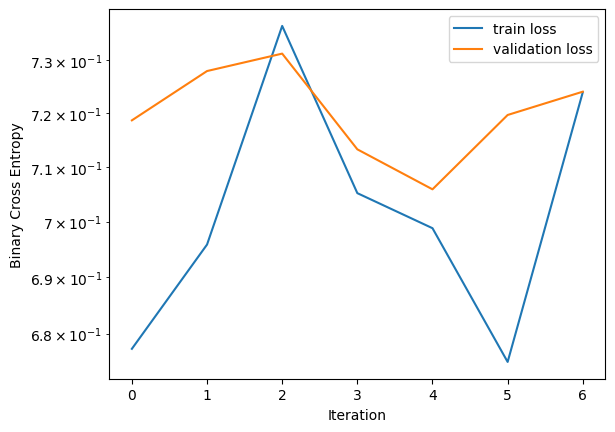

In [ ]:
plt.figure()
plt.semilogy(train_loss, label = 'train loss')
plt.semilogy(val_loss, label = 'validation loss')
plt.xlabel('Iteration')
plt.ylabel('Binary Cross Entropy')
plt.legend()

## Evaluation

In [ ]:
test_dl = iter(DL(test_ds, batch_size = batch_size, shuffle = True, pin_memory = True))

In [ ]:
test_batch, test_labels = next(test_dl)
test_batch = preprocess(test_batch)
test_batch = test_batch.to(device)
test_labels = test_labels.to(device)
test_pred = torch.nn.functional.sigmoid(resnet(test_batch))
print(confusion_matrix(test_pred, test_labels)) # With more training iterations, there seems to be increased model bias towards predicting pneumonia

tensor([[ 7.,  4.],
        [18.,  3.]])


In [ ]:
test_dl = iter(DL(test_ds, batch_size = batch_size, shuffle = True, pin_memory = True))

test_loss = []
accuracy_scores = []
prec_scores = []
rec_scores = []
f1_scores = []
resnet.eval()
for i in range(len(test_dl)):
    test_batch, test_labels = next(test_dl)
    test_batch = preprocess(test_batch)
    test_batch = test_batch.to(device)
    test_labels = test_labels.to(device)

    test_pred = resnet(test_batch)
    loss = criterion(torch.squeeze(test_pred), test_labels.float())
    test_loss.append(loss.item())

    acc = binary_accuracy(torch.nn.functional.sigmoid(test_pred), test_labels)
    prec = precision(torch.nn.functional.sigmoid(test_pred), test_labels)
    rec = recall(torch.nn.functional.sigmoid(test_pred), test_labels)
    f1_score = f1score(torch.nn.functional.sigmoid(test_pred), test_labels)
    accuracy_scores.append(acc)
    prec_scores.append(prec)
    rec_scores.append(rec)
    f1_scores.append(f1_score)

In [ ]:
mean_loss = np.mean(test_loss)
std_loss = np.std(test_loss)
min_loss = np.min(test_loss)
mean_acc = np.mean(accuracy_scores)
std_acc = np.std(accuracy_scores)
max_acc = np.max(accuracy_scores)
mean_prec = np.mean(prec_scores)
std_prec = np.std(prec_scores)
max_prec = np.max(prec_scores)
mean_rec = np.mean(rec_scores)
std_rec = np.std(rec_scores)
max_rec = np.max(rec_scores)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)
max_f1 = np.max(f1_scores)

print(f'Best estimate loss: {mean_loss} +- {std_loss}')
print(f'Lowest loss: {min_loss}')
print(f'Best estimate accuracy: {mean_acc} +- {std_acc}')
print(f'Best accuracy: {max_acc}')
print(f'Best estimate precision: {mean_prec} +- {std_prec}')
print(f'Best precision: {max_prec}')
print(f'Best estimate recall: {mean_rec} +- {std_rec}')
print(f'Best recall: {max_rec}')
print(f'Best estimate f1-score: {mean_f1} +- {std_f1}')
print(f'Best f1-score: {max_f1}')

Best estimate loss: 0.7116154283285141 +- 0.00849238382139047
Lowest loss: 0.6967295408248901
Best estimate accuracy: 0.3640625 +- 0.08105445218339336
Best accuracy: 0.5625
Best estimate precision: 0.4699332611832611 +- 0.1576053050646717
Best precision: 0.8571428571428571
Best estimate recall: 0.15290940290546562 +- 0.07639736748498642
Best recall: 0.4117647058823529
Best estimate f1-score: 0.22466906219985727 +- 0.09433808632639494
Best f1-score: 0.5


# CUDA memory management

In [ ]:
import gc

In [ ]:
# Run if CUDA memory runs out
torch.cuda.empty_cache()

# gives free and reserved memory
torch.cuda.mem_get_info()

# gives allocated memory
torch.cuda.memory_allocated()

# or run this again
!nvidia-smi

# garbage collection
gc.collect()

Wed May 15 03:56:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0              32W /  70W |  15099MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

13348

Great Early Stopping Paper https://page.mi.fu-berlin.de/prechelt/Biblio/stop_tricks1997.pdf

Memory management strategies https://medium.com/@soumensardarintmain/manage-cuda-cores-ultimate-memory-management-strategy-with-pytorch-2bed30cab1